# 예약 정보 분류 CNN 모델 만들기

## 0. 데이터 로드

In [4]:
%cd /content/drive/MyDrive/새싹_인공지능SW교육/프로젝트/새싹_최종프로젝트/tree_chatbot

import pandas as pd

reserve_info_data = pd.read_excel("./data/csv/CNN_reserv_info_sample_data.xlsx")
reserve_info_data.head()

/content/drive/MyDrive/새싹_인공지능SW교육/프로젝트/새싹_최종프로젝트/tree_chatbot


,input,label,label_info
0,내일 오후 2시에 8명 테이블 예약할게요.,1,"date,time,num_persons"
1,10월 5일 오후 2시에 성인 5명 룸으로 예약해주세요.,1,"date,time,num_persons"
2,"오늘 저녁 7시, 5명 예약되나요?",1,"date,time,num_persons"
3,내일모레 4시에 예약할 수 있습니까?,2,"date,time"
4,12월 2일 오전 10시에 예약을 좀 하려고 하는데요.,2,"date,time"


## 1. PADDING 길이 파악

In [2]:
!pip install konlpy
from konlpy.tag import Komoran
tokenizer = Komoran()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 80.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.6/465.6 KB 47.7 MB/s eta 0:00:00


In [7]:
# data의 모든 사용자 input문장을 형태소/품사로 분해하여 리스트에 저장

input_tokenized = [[token+"/"+POS for token, POS in tokenizer.pos(input)] for input in  reserve_info_data['input']]
input_tokenized[0]

['내일/NNG',
 '오후/NNG',
 '2시/NNP',
 '에/JKB',
 '8/SN',
 '명/NNB',
 '테이블/NNP',
 '예약/NNG',
 '하/XSV',
 'ㄹ게요/EF',
 './SF']

In [8]:
len(input_tokenized)

9

In [9]:
exclusion_tags = [
    'JKS', 'JKC', 'JKG', 'JKO', 'JKB', 'JKV', 'JKQ',
            'JX', 'JC',
            'SF', 'SP', 'SS', 'SE', 'SO',
            'EP', 'EF', 'EC', 'ETN', 'ETM',
            'XSN', 'XSV', 'XSA'
]

f = lambda x: x in exclusion_tags

core_input_tokenized = []

# i는 문장의 갯수
for i in range(len(input_tokenized)):
        temp = []
        # data_tokenized[0]=> 한 문장
        # j는 한 문장을 구성하는 '단어/품사' 갯수
        for j in range(len(input_tokenized[i])):
            # f에 품사를 넣음
            # exclusion_tags 리스트에 포함되지 않는 품사면 append!
            # 필요없는 품사가 아니면 append
            # (조사 같은 것들은 제외!)
            if f(input_tokenized[i][j].split('/')[1]) is False:
                temp.append(input_tokenized[i][j].split('/')[0])
        core_input_tokenized.append(temp)

In [10]:
input_tokenized[1] , core_input_tokenized[1]

(['10월 5일/NNP',
  '오후/NNG',
  '2시/NNP',
  '에/JKB',
  '성인/NNG',
  '5/SN',
  '명/NNB',
  '룸/NNG',
  '으로/JKB',
  '예약/NNG',
  '하/XSV',
  '아/EC',
  '주/VX',
  '시/EP',
  '어요/EF',
  './SF'],
 ['10월 5일', '오후', '2시', '성인', '5', '명', '룸', '예약', '주'])

토큰 길이 평균: 6.444444444444445
토큰 길이 최대: 9
토큰 길이 표준편차: 1.4989708403591155


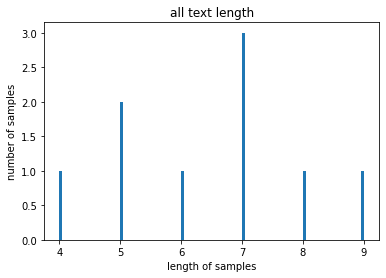

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# 불용어들을 제외한 '의미있는' 단어들의 길이들을 모아놓은 num_tokens
num_tokens = [len(tokens) for tokens in core_input_tokenized]
num_tokens = np.array(num_tokens)

# 평균값, 최댓값, 표준편차
print(f"토큰 길이 평균: {np.mean(num_tokens)}")
print(f"토큰 길이 최대: {np.max(num_tokens)}")
print(f"토큰 길이 표준편차: {np.std(num_tokens)}")

plt.title('all text length')
plt.hist(num_tokens, bins=100)
# bins는 가로축 구간의 개수
# (막대 그래프의 갯수)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
# PADDING 최대길이 9로 설정
MAX_LEN = 9

## 2. PADDING & 임베딩

In [12]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras import preprocessing
import pickle

class Preprocess:
    def __init__(self, word2index_dic='/content/drive/MyDrive/새싹_인공지능SW교육/프로젝트/새싹_자연어처리프로젝트/love_chatbot_sbert_v2(custom_data)/data/chatbot_dict/chatbot_dict.bin' ,userdic=None): # userdic 인자에는 사용자 정의 사전 파일 경로 입력가능
        # 단어 인덱스 사전 불러오기 추가
        if(word2index_dic != ''):
            f = open(word2index_dic, "rb")
            self.word_index = pickle.load(f)
            f.close()
            print("단어 사전 로드 완료..")
        else:
            self.word_index = None
            print("단어 사전 로드 실패..")

        # 형태소 분석기 초기화
        self.komoran = Komoran(userdic=userdic)

        # 제외할 품사
        # 참조 : https://docs.komoran.kr/firststep/postypes.html
        # 관계언 제거, 기호 제거
        # 어미 제거
        # 접미사 제거
        self.exclusion_tags = [
            'JKS', 'JKC', 'JKG', 'JKO', 'JKB', 'JKV', 'JKQ',
            # 주격조사, 보격조사, 관형격조사, 목적격조사, 부사격조사, 호격조사, 인용격조사
            'JX', 'JC',
            # 보조사, 접속조사
            'SF', 'SP', 'SS', 'SE', 'SO',
            # 마침표,물음표,느낌표(SF), 쉼표,가운뎃점,콜론,빗금(SP), 따옴표,괄호표,줄표(SS), 줄임표(SE), 붙임표(물결,숨김,빠짐)(SO)
            'EP', 'EF', 'EC', 'ETN', 'ETM',
            # 선어말어미, 종결어미, 연결어미, 명사형전성어미, 관형형전성어미
            'XSN', 'XSV', 'XSA'
            # 명사파생접미사, 동사파생접미사, 형용사파생접미사
        ]


    # 형태소 분석기 POS 태거
    def pos(self, sentence):
        return self.komoran.pos(sentence)

    # 불용어 제거 후 필요한 품사 정보만 가져오기
    def get_keywords(self, pos, without_tag=False):
        f = lambda x: x in self.exclusion_tags
        word_list = []
        for p in pos:
            if f(p[1]) is False:
                word_list.append(p if without_tag is False else p[0])
        return word_list

    # 키워드를 단어 인덱스 시퀀스로 변환
    def get_wordidx_sequence(self, keywords):
        if self.word_index is None:
            return []
        w2i = []
        for word in keywords:
            try:
                w2i.append(self.word_index[word])
            except KeyError:
                # 해당 단어가 사전에 없는 경우 OOV 처리
                w2i.append(self.word_index['OOV'])
        return w2i

p = Preprocess(word2index_dic='/content/drive/MyDrive/새싹_인공지능SW교육/프로젝트/새싹_자연어처리프로젝트/love_chatbot_sbert_v2(custom_data)/data/chatbot_dict/chatbot_dict.bin',
               userdic=None)

단어 사전 로드 완료..


In [14]:
inputs = reserve_info_data['input'].tolist()
inputs[:2]

['내일 오후 2시에 8명 테이블 예약할게요.', '10월 5일 오후 2시에 성인 5명 룸으로 예약해주세요.']

In [15]:
!pip install tqdm
from tqdm import tqdm

sequences = []
check_keywords = True
# text는 모든 문장들의 list
for sentence in tqdm(inputs):

    # 문장을 [(단어1,품사1),(단어2,품사2)...] 로 변환
    pos = p.pos(sentence)

    # get_keywords(pos, without_tag=True) => 불용어 처리 후 품사(태그)없이 단어들만의 list
    # keywords : 불용어 처리된 [(단어1,품사1),(단어2,품사2)...], list형
    keywords = p.get_keywords(pos, without_tag=True)

    # 첫번째 keywords 와 sequence[0] 어떻게 대응되는지 체크해보고 싶음
    if check_keywords is True:
      print(keywords)
      check_keywords = False
    # 태그없이 '단어'만 있는 keywords에서 [[단어1,단어2],[단어1,단어2,단어3]...]들을 인덱싱해줌
    # 우리가 만든 단어사전에 없으면(OOV token이므로 인덱스 1로 고정)
    seq = p.get_wordidx_sequence(keywords)
    sequences.append(seq)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


100%|██████████| 9/9 [00:00<00:00, 795.68it/s]

['내일', '오후', '2시', '8', '명', '테이블', '예약']


In [16]:
# sequences 불용어 처리 됌
sequences[:2]

[[433, 930, 3876, 735, 305, 5220, 346],
 [1, 930, 3876, 1485, 393, 305, 1964, 346, 35]]

In [17]:
MAX_SEQ_LEN = 9
padded_seqs = preprocessing.sequence.pad_sequences(sequences, maxlen=MAX_SEQ_LEN, padding='post')

In [18]:
len(padded_seqs[3]) ,len(padded_seqs[1]),len(padded_seqs[5])

(9, 9, 9)

In [105]:
# Import
import pandas as pd
import tensorflow as tf
from tensorflow.keras import preprocessing
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dense, Dropout, Conv1D, GlobalMaxPool1D, concatenate

# Load Data
reserve_info_data = pd.read_excel("./data/csv/CNN_reserv_info_sample_data.xlsx")
reserve_info_data.head()
inputs = reserve_info_data['input'].tolist()
labels = reserve_info_data['label'].tolist()

In [106]:
labels[:]

[0, 0, 0, 1, 1, 1, 2, 2, 2, 2]

In [107]:
# Load preprocessor
# p = Preprocess(word2index_dic='../../train_tools/dict/chatbot_dict.bin',
#                userdic='../../utils/user_dic.tsv')
# p = Proprocess() 객체 이미 만듬

In [108]:
sequences = []
for sentence in tqdm(inputs):
    pos = p.pos(sentence)
    keywords = p.get_keywords(pos, without_tag=True)
    seq = p.get_wordidx_sequence(keywords)
    sequences.append(seq)
sequences[0], sequences[1]

100%|██████████| 10/10 [00:00<00:00, 1651.50it/s]


([433, 930, 3876, 735, 305, 5220, 346],
 [1, 930, 3876, 1485, 393, 305, 1964, 346, 35])

In [109]:
# MAX_SEQ_LEN = 9

padded_seqs = preprocessing.sequence.pad_sequences(sequences, maxlen=MAX_SEQ_LEN, padding='post')
padded_seqs[0], padded_seqs[3]

(array([ 433,  930, 3876,  735,  305, 5220,  346,    0,    0], dtype=int32),
 array([ 433, 5257,  417,   15,  346,   50,   16,    0,    0], dtype=int32))

In [110]:
len(padded_seqs)

10

In [111]:
len(padded_seqs[0]), len(padded_seqs[3])

(9, 9)

In [112]:
ds = tf.data.Dataset.from_tensor_slices((padded_seqs, labels))
ds = ds.shuffle(len(inputs))

In [113]:
# set train & validation & test size
train_size = int(len(padded_seqs) * 0.7)
val_size = int(len(padded_seqs) * 0.2)
test_size = int(len(padded_seqs) * 0.1)

In [114]:
# batch 100 => 1

train_ds = ds.take(train_size).batch(1)
val_ds = ds.take(train_size).take(val_size).batch(1)
test_ds = ds.take(train_size + val_size).take(test_size).batch(1)

In [115]:
# Hyperparameter
dropout_prob = 0.5
EMB_SIZE = 128
EPOCH = 3
VOCAB_SIZE = len(p.word_index) + 1

In [116]:
# CNN model definition
input_layer = Input(shape=(MAX_SEQ_LEN, ))
embedding_layer = Embedding(VOCAB_SIZE, EMB_SIZE, input_length=MAX_SEQ_LEN)(input_layer)
dropout_emb = Dropout(rate=dropout_prob)(embedding_layer)

In [117]:
conv1 = Conv1D(
    filters=128,
    kernel_size=3,
    padding='valid',
    activation=tf.nn.relu)(dropout_emb)
pool1 = GlobalMaxPool1D()(conv1)

conv2 = Conv1D(
    filters=128,
    kernel_size=4,
    padding='valid',
    activation=tf.nn.relu)(dropout_emb)
pool2 = GlobalMaxPool1D()(conv2)

conv3 = Conv1D(
    filters=128,
    kernel_size=5,
    padding='valid',
    activation=tf.nn.relu)(dropout_emb)
pool3 = GlobalMaxPool1D()(conv3)

concat = concatenate([pool1, pool2, pool3])

hidden = Dense(128, activation=tf.nn.relu)(concat)
dropout_hidden = Dropout(rate=dropout_prob)(hidden)
logits = Dense(3, name='logits')(dropout_hidden)
predictions = Dense(3, activation=tf.nn.softmax)(logits)

In [118]:
# CNN model create
model = Model(inputs=input_layer, outputs=predictions)
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [119]:
# train model
model.fit(train_ds, validation_data=val_ds, epochs=EPOCH, verbose=1)

Epoch 1/3
7/7 [==============================] - 6s 252ms/step - loss: 1.1513 - accuracy: 0.1429 - val_loss: 1.0065 - val_accuracy: 0.5000
Epoch 2/3
7/7 [==============================] - 0s 12ms/step - loss: 1.0135 - accuracy: 0.5714 - val_loss: 1.0659 - val_accuracy: 0.5000
Epoch 3/3
7/7 [==============================] - 0s 12ms/step - loss: 1.0844 - accuracy: 0.2857 - val_loss: 0.8503 - val_accuracy: 1.0000


In [120]:
# evaluate model
loss, accuracy = model.evaluate(test_ds, verbose=1)
print("Accuracy: %f" % (accuracy * 100))
print("loss : %f" % (loss))

# save model
model.save('./models/CNN_reserve_info/sample_reserve_info_model.h5')

1/1 [==============================] - 0s 14ms/step - loss: 0.8166 - accuracy: 1.0000
Accuracy: 100.000000
loss : 0.816648


# 3. 모델 테스트

In [11]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras import preprocessing
import pickle

class Preprocess:
    def __init__(self, word2index_dic='/content/drive/MyDrive/새싹_인공지능SW교육/프로젝트/새싹_자연어처리프로젝트/love_chatbot_sbert_v2(custom_data)/data/chatbot_dict/chatbot_dict.bin' ,userdic=None): # userdic 인자에는 사용자 정의 사전 파일 경로 입력가능
        # 단어 인덱스 사전 불러오기 추가
        if(word2index_dic != ''):
            f = open(word2index_dic, "rb")
            self.word_index = pickle.load(f)
            f.close()
            print("단어 사전 로드 완료..")
        else:
            self.word_index = None
            print("단어 사전 로드 실패..")

        # 형태소 분석기 초기화
        self.komoran = Komoran(userdic=userdic)

        # 제외할 품사
        # 참조 : https://docs.komoran.kr/firststep/postypes.html
        # 관계언 제거, 기호 제거
        # 어미 제거
        # 접미사 제거
        self.exclusion_tags = [
            'JKS', 'JKC', 'JKG', 'JKO', 'JKB', 'JKV', 'JKQ',
            # 주격조사, 보격조사, 관형격조사, 목적격조사, 부사격조사, 호격조사, 인용격조사
            'JX', 'JC',
            # 보조사, 접속조사
            'SF', 'SP', 'SS', 'SE', 'SO',
            # 마침표,물음표,느낌표(SF), 쉼표,가운뎃점,콜론,빗금(SP), 따옴표,괄호표,줄표(SS), 줄임표(SE), 붙임표(물결,숨김,빠짐)(SO)
            'EP', 'EF', 'EC', 'ETN', 'ETM',
            # 선어말어미, 종결어미, 연결어미, 명사형전성어미, 관형형전성어미
            'XSN', 'XSV', 'XSA'
            # 명사파생접미사, 동사파생접미사, 형용사파생접미사
        ]


    # 형태소 분석기 POS 태거
    def pos(self, sentence):
        return self.komoran.pos(sentence)

    # 불용어 제거 후 필요한 품사 정보만 가져오기
    def get_keywords(self, pos, without_tag=False):
        f = lambda x: x in self.exclusion_tags
        word_list = []
        for p in pos:
            if f(p[1]) is False:
                word_list.append(p if without_tag is False else p[0])
        return word_list

    # 키워드를 단어 인덱스 시퀀스로 변환
    def get_wordidx_sequence(self, keywords):
        if self.word_index is None:
            return []
        w2i = []
        for word in keywords:
            try:
                w2i.append(self.word_index[word])
            except KeyError:
                # 해당 단어가 사전에 없는 경우 OOV 처리
                w2i.append(self.word_index['OOV'])
        return w2i

p = Preprocess(word2index_dic='/content/drive/MyDrive/새싹_인공지능SW교육/프로젝트/새싹_자연어처리프로젝트/love_chatbot_sbert_v2(custom_data)/data/chatbot_dict/chatbot_dict.bin',
               userdic=None)

단어 사전 로드 완료..


In [14]:
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import preprocessing
import gc

# 의도 분류 모델 모듈
class IntentModel:
    def __init__(self, model_name, preprocess):

        # 의도 클래스별 레이블블
        self.labels = {0: "date/time/num_persons", 1: "date/time", 2: "date/num_persons"}

        # 의도 분류 모델 불러오기
        self.model = load_model(model_name)

        # 챗봇 텍스트 전처리기
        self.p = preprocess

    # 의도 클래스 예측
    def predict_class(self, query):
        # 형태소 분석
        pos = self.p.pos(query)

        # 문장내 키워드 추출(불용어 제거)
        keywords = self.p.get_keywords(pos, without_tag=True)
        sequences = [self.p.get_wordidx_sequence(keywords)]





        # PADDING 최대 길이 설정
        # 단어 시퀀스 벡터 크기
        MAX_SEQ_LEN = 9

        # 패딩처리
        padded_seqs = preprocessing.sequence.pad_sequences(sequences, maxlen=MAX_SEQ_LEN, padding='post')

        predict = self.model.predict(padded_seqs)
        predict_class = tf.math.argmax(predict, axis=1)
        return predict_class.numpy()[0]

In [6]:
!pip install konlpy
from konlpy.tag import Komoran
tokenizer = Komoran()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 67.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.6/465.6 KB 53.9 MB/s eta 0:00:00


In [16]:
%cd /content/drive/MyDrive/새싹_인공지능SW교육/프로젝트/새싹_최종프로젝트/tree_chatbot

# p는 이미 만듬
# p = Preprocess(word2index_dic='../train_tools/dict/chatbot_dict.bin',
#                userdic='../utils/user_dic.tsv')

intent = IntentModel(model_name='./models/CNN_reserve_info/sample_reserve_info_model.h5', preprocess=p)

query = "내일 오후 2시에 8명 테이블 예약할게요.	"
predict = intent.predict_class(query)
predict_label = intent.labels[predict]
print("="*30)
print(query)
print("의도 예측 클래스 : ", predict)
print("의도 예측 레이블 : ", predict_label)


/content/drive/MyDrive/새싹_인공지능SW교육/프로젝트/새싹_최종프로젝트/tree_chatbot
1/1 [==============================] - 0s 113ms/step
내일 오후 2시에 8명 테이블 예약할게요.	
의도 예측 클래스 :  0
의도 예측 레이블 :  date/time/num_persons


AttributeError: ignored

In [125]:
query = "저희 금요일에 성인 5명이요."
predict = intent.predict_class(query)
predict_label = intent.labels[predict]
print("="*30)
print(query)
print("의도 예측 클래스 : ", predict)
print("의도 예측 레이블 : ", predict_label)

1/1 [==============================] - 0s 19ms/step
저희 금요일에 성인 5명이요.
의도 예측 클래스 :  2
의도 예측 레이블 :  date/num_persons


In [126]:
query = "모레 4시에 예약할 수 있나요?"
predict = intent.predict_class(query)
predict_label = intent.labels[predict]
print("="*30)
print(query)
print("의도 예측 클래스 : ", predict)
print("의도 예측 레이블 : ", predict_label)

1/1 [==============================] - 0s 62ms/step
모레 4시에 예약할 수 있나요?
의도 예측 클래스 :  2
의도 예측 레이블 :  date/num_persons


In [127]:
query = "내일모레 4시에 예약할 수 있습니까?"
predict = intent.predict_class(query)
predict_label = intent.labels[predict]
print("="*30)
print(query)
print("의도 예측 클래스 : ", predict)
print("의도 예측 레이블 : ", predict_label)

1/1 [==============================] - 0s 27ms/step
내일모레 4시에 예약할 수 있습니까?
의도 예측 클래스 :  2
의도 예측 레이블 :  date/num_persons


In [128]:
query = "4월 5일로 3명 예약해주시겠어요?"
predict = intent.predict_class(query)
predict_label = intent.labels[predict]
print("="*30)
print(query)
print("의도 예측 클래스 : ", predict)
print("의도 예측 레이블 : ", predict_label)

1/1 [==============================] - 0s 30ms/step
4월 5일로 3명 예약해주시겠어요?
의도 예측 클래스 :  2
의도 예측 레이블 :  date/num_persons


In [129]:
query = "10월 5일 오후 2시에 성인 5명 룸으로 예약해주세요."
predict = intent.predict_class(query)
predict_label = intent.labels[predict]
print("="*30)
print(query)
print("의도 예측 클래스 : ", predict)
print("의도 예측 레이블 : ", predict_label)

1/1 [==============================] - 0s 20ms/step
10월 5일 오후 2시에 성인 5명 룸으로 예약해주세요.
의도 예측 클래스 :  0
의도 예측 레이블 :  date/time/num_persons
